# Comparison of Autonecoder and PCA for image compression

Hi and welcome! Throughout this module, you learned a lot about Autoencoders and their application. However, Autoencoder is not the only algorithm for dimensionality reduction. In this lab, we will compare Autoencoder with one of the most famous dimensionality reduction techniques in classical machine learning. 

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to compress the image using dimensionality reduction techniques
- How to build a PCA model
- How to build a classical Autoencoder 
    - How to "tie" weights of a PyTorch model
- How to evaluate dimensionality reduction techniques
- How to outperform PCA with deep autoencoders

# 0 - Download data

In [1]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/5_autoencoder/autoencoder_vs_pca/template.zip')
!unzip -q template.zip

# 1 - Import packages

`numpy` provides a lot of useful mathematical functions available in `linalg` subpackage that we will import under `LA` name. To use it, you will have to write your function with `LA.` at the beginning (e.g. `LA.norm()`).

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import numpy.linalg as LA
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
def show(img, cmap='gray', title=None):
    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

## Config

In [4]:
# VALIDATION_FIELD[cls] Config

class Config:
    seed = 21
    num_hidden = 20
    num_epochs = 2000
    num_features = 450
    num_examples = 561
    learning_rate = 0.005
    fname = 'feynman.jpg'
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# 2 - Data

For our experiment, we will use an image of a legendary American physicist, [Richard Feynman](https://en.wikipedia.org/wiki/Richard_Feynman), whose contribution to theoretical physics made a long-lasting impact on modern science. The image itself is grayscale with a size of 561 by 450 pixels, and we will treat each row of the image as a separate data example. So, our **dataset** has **561 data samples**, and each sample has **450 features**.

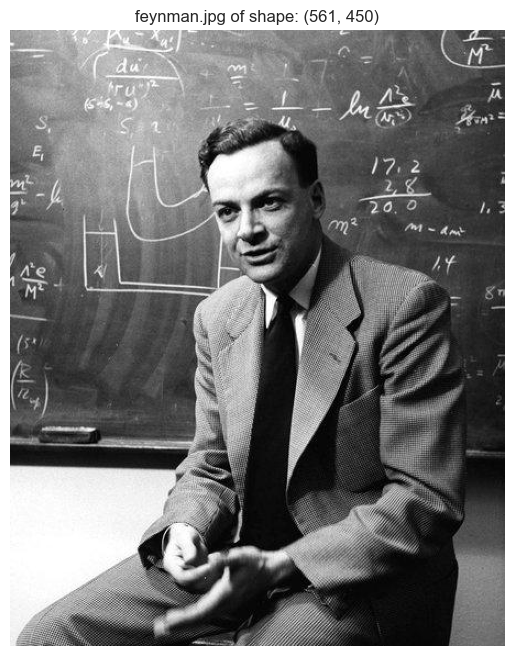

In [6]:
img = Image.open(Config.fname)
np_img = np.asarray(img)
show(np_img, title=f'{Config.fname} of shape: {np_img.shape}')

# 3 - Task

In this lab, we will focus on image compression, meaning that we will try to find a smaller representation of the original image, and then use this represantation to reconstruct the original image. We would like to compress **94%** of the information in the original image, which in our case means keeping **0.06 * 450 = 27** pixels (features) in each row. We will evaluate the quality of each algorithm using Mean Square Loss between the original and reconstructed image.

# 4 - PCA

Principal Component Analysis, PCA, is a simple linear transformation technique that is used primarily for dimensionality reduction and has numerous applications, such as stock market predictions, the analysis of gene expression data, and many more. 

Any task, such as image compression, naturally comes at the expense of reconstructed quality, but the goal of PCA is to choose features, **principal components**, that are the most important for retaining the information in the dataset. Not surprisingly, the more features we preserve, the more information can be reconstructed using PCA's transformation matrix. Therefore, the idea of PCA is simple — reduce the number of variables of a data set while preserving as much information as possible.

To implement PCA, we will have to do the following steps:
1. Standardize the data
2. Compute the covariance matrix
3. Obtain the Eigenvectors and Eigenvalues from the covariance matrix;
4. Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace $(k≤$n_features), and construct the projection matrix $W$ from the selected $k$ eigenvectors;
5. Transform the original dataset $X$ via $W$ to obtain a $k$-dimensional feature subspace $Y$.

## Step 1: Standardize the data

Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. 

Let's transform the data onto unit scale, which is a requirement for the optimal performance of many machine learning algorithms. We will do it using standard score:
$$z = \frac{x - \mu}{\sigma}\tag{1}$$

In [48]:
# VALIDATION_FIELD[func] normalize

def normalize(X):
    ### START CODE HERE ### (≈3 lines of code)
    mean = X.mean(axis=0).reshape(1, -1)
    std = X.std(axis=0).reshape(1, -1)
    X_norm = (X - mean)/ std
    ### END CODE HERE ###
    return X_norm, mean, std

In [49]:
X = np.asarray([[12, 15, 20, 24, 27, 30, 63], 
                [34, 31, 29, 88, 76, 80, 89], 
                [45, 50, 43, 60, 65, 59, 89]]).T
X_norm, mean, std = normalize(X)
print('Normalized:')
print(X_norm)
print('mean:')
print(mean)
print('std:')
print(std)

Normalized:
[[-0.97192436 -1.03627392 -0.94655962]
 [-0.78117285 -1.15141547 -0.60145976]
 [-0.46325367 -1.2281765  -1.08459956]
 [-0.20891832  1.03627392  0.08873996]
 [-0.01816681  0.57570773  0.43383983]
 [ 0.1725847   0.7292298   0.01971999]
 [ 2.27085131  1.07465444  2.09031916]]
mean:
[[27.28571429 61.         58.71428571]]
std:
[[15.72726737 26.05488712 14.48855988]]


**Expected output:**

<table>
    <tr>
        <td><b>Normalized:</b></td>
       <td> [[-0.97192436 -1.03627392 -0.94655962] <br>
 [-0.78117285 -1.15141547 -0.60145976]<br>
 [-0.46325367 -1.2281765  -1.08459956]<br>
 [-0.20891832  1.03627392  0.08873996]<br>
 [-0.01816681  0.57570773  0.43383983]<br>
 [ 0.1725847   0.7292298   0.01971999]<br>
 [ 2.27085131  1.07465444  2.09031916]]</td>
    </tr>
    <tr>
        <td><b>mean:</b></td>
       <td>[[27.28571429 61.         58.71428571]]</td>
    </tr>
    <tr>
        <td><b>std:</b></td>
       <td>[[15.72726737 26.05488712 14.48855988]]</td>
    </tr>
</table>

## Step 2: Compute covariance matrix

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $C$, which is a $n_{features}×n_{features}$ matrix where each element represents the covariance between two features.

To compute an element of $C$ we have to do the following:

$$c_{j,k} = \frac{1}{n-1}\sum_{i=1}^{n}(x_j^i-\mu_j)(x_k^i-\mu_k)$$

where $\mu_j$ is the mean value in the $jth$ column, and $n$ is a number of features. 

Since we have already normalized our dataset, all rows have a mean of 0. Therefore, we can simplify the equation above to:

$$c_{j,k} = \frac{1}{n-1}\sum_{i=1}^{n}x_j^ix_k^i$$

Which can be paralized using:

$$ C = \frac{1}{n-1} X^TX $$

where X is a normalized dataset with means of 0

**Excercise:** implement `compute_covariance` function using the formula above.

In [50]:
# VALIDATION_FIELD[func] compute_covariance

def compute_covariance(X_norm):
    ### START CODE HERE ### (≈2 lines of code)
    n = X_norm.shape[1]
    C = (1/(n-1)) * np.matmul(X_norm.T, X_norm)
    ### END CODE HERE ###
    return C

In [51]:
C = compute_covariance(X_norm)
print('Covariance:')
print(C)

Covariance:
[[3.5        2.4074353  3.3080298 ]
 [2.4074353  3.5        2.80398991]
 [3.3080298  2.80398991 3.5       ]]


**Expected output:**

<table>
    <tr>
        <td><b>Covariance:</b></td>
       <td> [[3.5        2.4074353  3.3080298 ]<br>
 [2.4074353  3.5        2.80398991]<br>
 [3.3080298  2.80398991 3.5       ]]<td>
    </tr>
</table>

## Step 3: Compute eigenvalues and eignevectors

The eigenvectors and eigenvalues of a covariance matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes. The eigenvector that has the largest corresponding eigenvalue represents the direction of maximum variance. An eigenvector $v$ satisfies the following condition:
$$ Cv = \lambda v $$

where $C$ is a covariance matrix, $v$ is an eigenvector, and $\lambda$ is a corresponding eigenvalue. 

**Excercise:** Let's find all eigenvectors and corresponding eigenvalues of covariance matrix. **Hint** use `LA` submodule of `numpy` library.

In [52]:
# VALIDATION_FIELD[func] get_eigendecomposition

def get_eigendecomposition(C):
    ### START CODE HERE ### (≈1 line of code)
    C = np.array(C)
    eig_vals, eig_vectors = LA.eig(C)
    ### END CODE HERE ###
    return eig_vals, eig_vectors

In [53]:
eig_vals, eig_vectors = get_eigendecomposition(C)
print('eigenvalues:')
print(eig_vals)
print('eigenvectors:')
print(eig_vectors)

eigenvalues:
[9.19580823 0.13297001 1.17122176]
eigenvectors:
[[-0.58136163 -0.60766564  0.54107405]
 [-0.54371011 -0.20458362 -0.8139563 ]
 [-0.60530817  0.76739039  0.21145688]]


**Expected output:**

<table>
    <tr>
        <td><b>eigenvectors:</b></td>
        <td>[9.19580823 0.13297001 1.17122176]<td>
    </tr>
    <tr>
        <td><b>eigenvectors:</b></td>
       <td> [[-0.58136163 -0.60766564  0.54107405]<br>
 [-0.54371011 -0.20458362 -0.8139563 ]<br>
 [-0.60530817  0.76739039  0.21145688]]</td>
    </tr>
</table>

Let's visualize first 50 eigenvalues for the image of Feynman. 

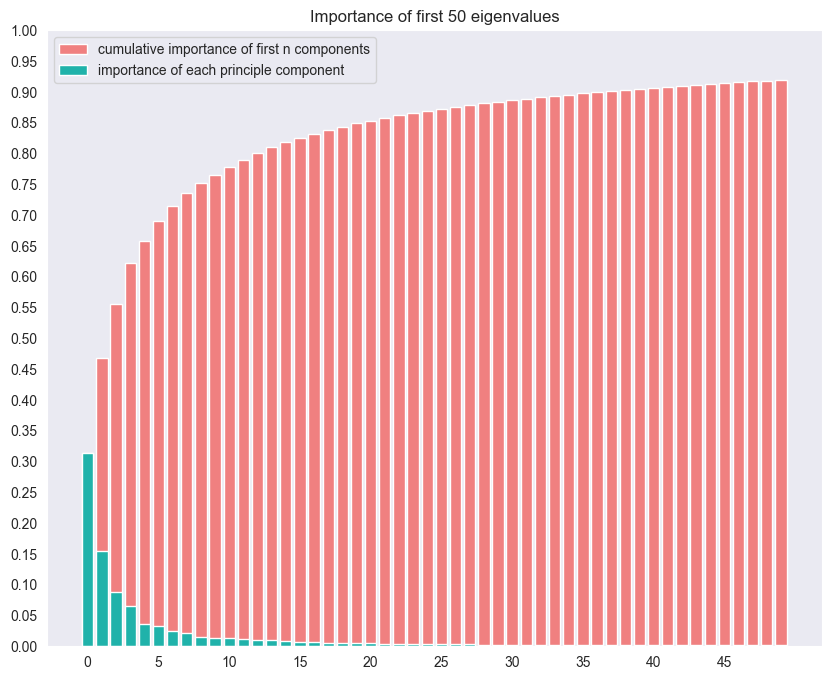

In [54]:
def plot_eig_vals(X, first_n = 50):
    X_norm, mean, std = normalize(X) 
    C = compute_covariance(X_norm) 
    eig_vals, _ = get_eigendecomposition(C)
    eig_vals = np.sort(eig_vals.astype('float'))[::-1]
    eig_scores = eig_vals / eig_vals.sum()
    plt.figure(figsize=(10, 8))
    plt.bar(range(first_n), np.cumsum(eig_scores)[:first_n], color='lightcoral',
            label='cumulative importance of first n components')
    plt.bar(range(first_n), eig_scores[:first_n], color='lightseagreen',
            label='importance of each principle component') 
    plt.yticks(np.arange(0, 1+0.05, 0.05))
    plt.xticks(np.arange(0, first_n, 5))
    plt.legend()
    plt.grid()
    plt.title(f'Importance of first {first_n} eigenvalues')
    plt.show()
plot_eig_vals(np_img)

As you can see from the diagram above, it is enough to take only 20 eigenvectors to explain 85% of the variance in the original dataset.

## Step 4: Filter top-n eigen vectors by their eigenvalues

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. 

In order to decide which eigenvector(s) can be dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data - those are the ones can be dropped.

So now we need to implement following steps:
1. Compute eigenvectors $(e_1,e_2,...,e_d)$ and corresponding eigenvalues $(λ_1,λ_2,...,λ_d)$.
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.
2. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $n_{features}×k$ dimensional matrix $W$ (where every row represents an eigenvector)
3. Use this $n_{features}×k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $$Y=X_{normalized}×W\tag{9}$$ (where $X_{normalized}$ is an normalized input matrix with shape $n_{samples}×n_{features}$, and $Y$ is the transformed $n_{samples}×k$-dimensional matrix of samples in the new subspace.)

4. To restore input matrix $X$ we should do next operation: $$X_{restored} = Y×W^T.\tag{10}$$ But don't forget that we worked with normalized data, so we also have to put it to the initial form back (use `norm_parameters` from `normalization` function).

**Excercise:** implement `filter_eigenvectors` function that returns a transformation matrix $W$ composed of $k$ eigenvectors that correspond to $k$ largest eigenvalues.

In [55]:
# VALIDATION_FIELD[func] filter_eigenvectors

def filter_eigenvectors(eig_vals, eig_vectors, k):
    ### START CODE HERE ### (≈3 lines of code)
    idx = np.argsort(eig_vals)[::-1]
    W = eig_vectors[:, idx[:k]]
    ### END CODE HERE ###
    return W

In [56]:
W = filter_eigenvectors(eig_vals, eig_vectors, 2)
print('W:')
print(W)

W:
[[-0.58136163  0.54107405]
 [-0.54371011 -0.8139563 ]
 [-0.60530817  0.21145688]]


**Expected output:**

<table>
    <tr>
        <td><b>W:</b></td>
        <td>[[-0.58136163  0.54107405]<br>
 [-0.54371011 -0.8139563 ]<br>
 [-0.60530817  0.21145688]]<td>
    </tr>
</table>

## Step 5: apply transformation

Finally, let's put everything together into one class. Just as a reminder, here are the steps you need to perform to obtain a low dimensional representation of the data:
1. Standardize the data
2. Compute the covariance matrix
3. Obtain the Eigenvectors and Eigenvalues from the covariance matrix;
4. Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace $(k≤$n_features), and construct the projection matrix $W$ from the selected $k$ eigenvectors;
5. Transform the original dataset $X$ via $W$ to obtain a $k$-dimensional feature subspace $Y$.

**Excercise:** implement full PCA model

In [57]:
# VALIDATION_FIELD[cls] PCA

class PCA:
    def __init__(self, k):
        self.k = k
        self.W = None
        self.mean = None
        self.std = None

    def forward(self, X):  
        ### START CODE HERE ### (≈6 lines of code)
        # Step 1: Normalization
        X_norm, self.mean, self.std = normalize(X)
        # Step 2: Covariance
        C = compute_covariance(X_norm)
        # Step 3: Eigendecomposition
        eig_vals, eig_vectors = get_eigendecomposition(C)
        # Step 4: Filter vectors
        self.W = filter_eigenvectors(eig_vals, eig_vectors, self.k)
        # Step 5: Transformation
        Y = np.matmul(X_norm, self.W)
        ### END CODE HERE ###
        return Y

    def reconstruct(self, Y):
        ### START CODE HERE ### (≈2 lines of code)
        # reconstruct
        X = np.matmul(Y, self.W.T)
        # renormalize
        X = X * self.std + self.mean
        ### END CODE HERE ###
        return X

In [58]:
X = np.asarray([[27, 30, 63, 8, 67, 43, 11, 15, 67], 
                [76, 80, 89, 53, 48, 66, 45, 50, 85], 
                [65, 59, 89, 53, 43, 31, 33, 40, 80]]).T
model = PCA(k=2)
Y = model.forward(X)
X_rec = model.reconstruct(Y)
print('Transformed:')
print(Y)
print('Reconstructed:')
print(X_rec)

Transformed:
[[ 0.4987817  -0.77916695]
 [ 0.52491594 -0.63362282]
 [ 2.54080906 -0.13304767]
 [-1.16895571 -0.79816708]
 [-0.38791837  1.7447632 ]
 [-0.61210855  0.6849082 ]
 [-2.04264757 -0.13743894]
 [-1.54324943 -0.22181787]
 [ 2.19037293  0.27358991]]
Reconstructed:
[[27.03623103 75.02876613 66.13137738]
 [30.20542161 74.49332789 65.4146489 ]
 [62.89164264 91.90470154 85.61635192]
 [ 7.7962599  58.46159625 46.63785938]
 [66.83774559 52.34950262 37.93332241]
 [43.37640246 55.90989848 42.75382468]
 [10.95854713 46.11121386 31.7055618 ]
 [14.94161105 51.5652142  38.17670286]
 [66.95613859 86.17577905 78.63035067]]


**Expected output:**

<table>
    <tr>
        <td><b>Transformed:</b></td>
        <td>[[ 0.4987817  -0.77916695]<br>
 [ 0.52491594 -0.63362282]<br>
 [ 2.54080906 -0.13304767]<br>
 [-1.16895571 -0.79816708]<br>
 [-0.38791837  1.7447632 ]<br>
 [-0.61210855  0.6849082 ]<br>
 [-2.04264757 -0.13743894]<br>
 [-1.54324943 -0.22181787]<br>
 [ 2.19037293  0.27358991]]<td>
    </tr>
    <tr>
        <td><b>Reconstructed:</b></td>
        <td>[[27.03623103 75.02876613 66.13137738]<br>
 [30.20542161 74.49332789 65.4146489 ]<br>
 [62.89164264 91.90470154 85.61635192]<br>
 [ 7.7962599  58.46159625 46.63785938]<br>
 [66.83774559 52.34950262 37.93332241]<br>
 [43.37640246 55.90989848 42.75382468]<br>
 [10.95854713 46.11121386 31.7055618 ]<br>
 [14.94161105 51.5652142  38.17670286]<br>
 [66.95613859 86.17577905 78.63035067]]<td>
    </tr>
</table>

## Run on an image

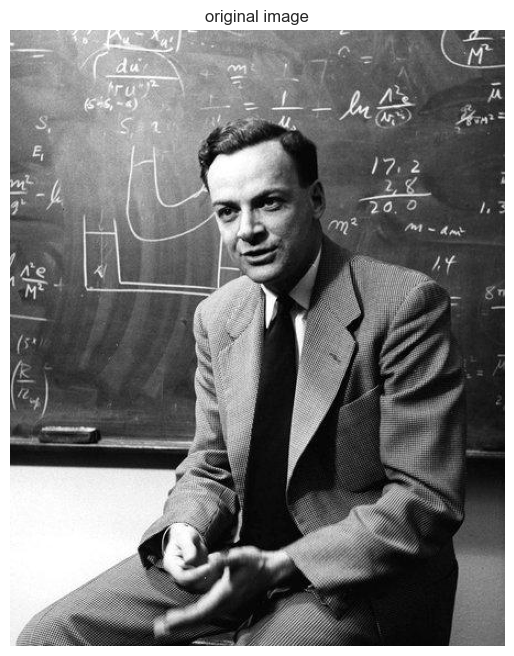

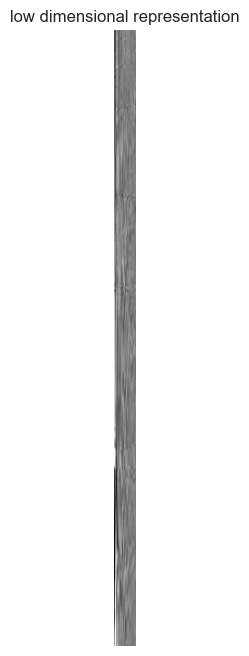

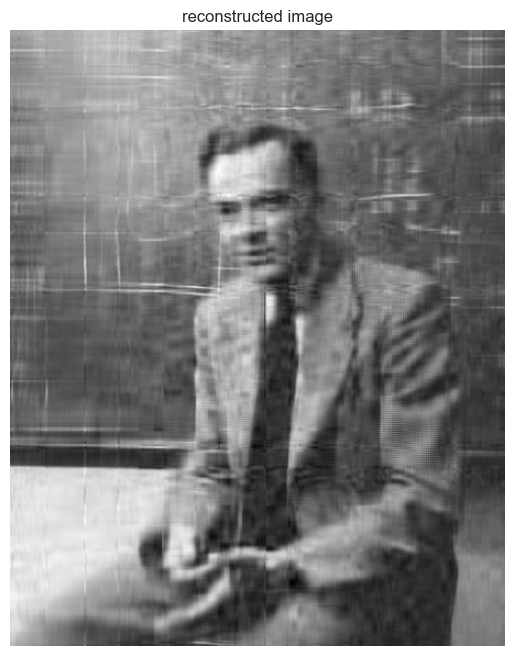

In [59]:
model = PCA(k = Config.num_hidden)
Y = model.forward(np_img)
X_rec = model.reconstruct(Y)
show(np_img, title = 'original image')
show(Y, title = 'low dimensional representation')
show(X_rec, title = 'reconstructed image')

As you can see some of the finer details were lost due to the inoformation discarded, but let's look at the correlation of the features in the hidden representation of the image.

In [60]:
def plot_covariance(x):
    figure = plt.figure(figsize=(10,6))
    plt.title('Correlation between features')
    cov = compute_covariance(x)
    sns.heatmap(cov, annot=False)
    plt.show()

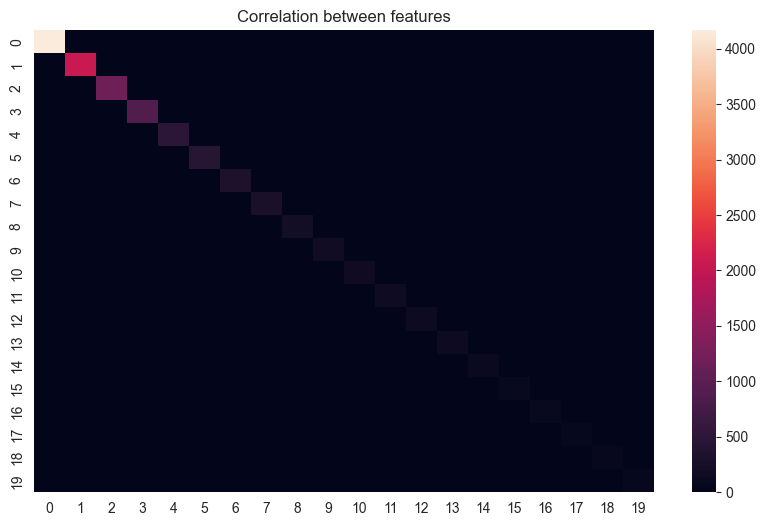

In [61]:
plot_covariance(Y)

As you can see, using PCA, we were able to find 20 principal components that are **uncorrelated** with each other and sort them in decreasing order from the most important to the least important. But how well did we do on the reconstruction loss? Let's find out!

In [62]:
def mse_loss(input, target):
    assert input.shape == target.shape, 'array shapes must be the same'
    err = input - target
    return 1/(err.shape[0]*err.shape[1]) * np.trace(np.matmul(err, err.T))

In [63]:
loss = mse_loss(np_img, X_rec)
print('MSE Reconstruction loss:', loss)

MSE Reconstruction loss: 494.49691622588693


**Expected output:**

MSE Reconstruction loss: 494.496916225887

# 5 - Autoencoder

Now, it's time to put Autoencoder to the test. We will first test the Tied 1-layer Autoencoder, the one that is the most similar by its structure to PCA, and then try Deep Autoencoder to see if we can improve our results.

## Tied 1-layer Autoencoder

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/tiedautoencoder.png">

The overall idea of an Autoencoder is very similar to the PCA. By default, Autoencoder compresses original input of shape $n_{batch}\times n_{features}$ to a hidden representation of shape $n_{batch}\times n_{hidden}$, where $n_{hidden} < n_{features}$ (this is true for all under complete autoencoders). In the Tied 1-layer Autoencoder, the most simple out of all autoencoders, this transformation is done by a single matrix multiplication with a matrix $W$ of shape $n_{features}\times n_{hidden}$:

$$ X \times W = Y $$

where Y is a hidden representation of X with the shape of $n_{batch}\times n_{hidden}$. To reconstruct the original image, all we have to do is to multiply $Y$ with a transposed $W$:

$$ Y \times W^T = \hat{X} $$

The training of any Autoencder is done through calculating the reconstruction loss, and optimizing the matrix $W$ to obtain a smaller rocnstruction error:

$$ \text{ReconstructionLoss} = \frac{1}{N}(X - \hat{X})^2 $$

Therfore, if we substitute for $ \hat{X} $ we get:

$$ \text{ReconstructionLoss} = \frac{1}{N}(X - X \times W \times W^T)^2 $$

So, the minimum will be achieved if:

$$ (X - X \times W \times W^T)^2 = 0 $$
$$ X \times W \times W^T = X $$
$$ X^{-1} \times X \times W \times W^T = X^{-1} \times X $$
$$ W \times W^T = I $$

This is possible if and only if $W$ is an **orthogonal** matrix. However, since $W$ is a non-square matrix, it cannot be orthogonal. Therefore, the optimization algorithm will try to find a suboptimal minimum to minimize the reconstruction error. 

**Important:** reconstruction loss **cannot** be equal to 0, because $W$ is a **non-square** matrix.

## How is it different from PCA?

If we look back at the PCA algorithm, it has the same objective in its core, but it is achieved differently.  In the Autoencoder, we optimized iteratively to try to achieve an **orthogonal** matrix $W$ that would minimize the error (which is impossible, by the way). In PCA, we construct a perfect square **orthogonal** matrix $W$ using the eigenvectors of the covariance matrix $C$ (since $C$ is a symmetric matrix, its eigenvectors are orthogonal to each other) and then discard eigenvectors of low importance to get a non-square transformation matrix.

Which transformation matrix is better in terms of reconstruction loss? We are about to find out!

## Implementation

To implement the TiedAutoencoder, we will need to implement the following methods:
* `__init__`:

 - In init all we need to do is to declare a matrix $W$ of shape $n_{features} \times n_{hidden}$
 - You will need to create an empty tensor of shape $n_{features} \times n_{hidden}$ and then initialize it using uniform  distribution from range $(-\frac{1}{\sqrt {n_{features}}}, \frac{1}{\sqrt {n_{features}}})$
 - Finally register self.W as a trainable parameter using `nn.Parameter`
* `preprocess`:
    - perform normalization using $ x_{norm} = (x - \mu)/\sigma $
* `postprocess`:
    - perform renormalization using $\mu$ and $\sigma$ saved from `preprocess`
* `forward`:
    - compute the hidden representation of an image, $Y$, and reconstructed image $\hat{X}$
    - your function should return a tuple $(\hat{X}, Y)$

**Excercise:** implement Tied 1-layer Autoencoder. 

In [64]:
# VALIDATION_FIELD[cls] TiedAutoencoder

class TiedAutoencoder(nn.Module):
    def __init__(self, num_features=Config.num_features, num_hidden=Config.num_hidden):
        super(TiedAutoencoder, self).__init__()
        ### START CODE HERE ### (≈1-3 lines of code)
        self.W = nn.Parameter(torch.empty(num_features, num_hidden).uniform_(-1/np.sqrt(num_features), 1/np.sqrt(num_features)))
        ### END CODE HERE ###

    def preprocess(self, x):
        ### START CODE HERE ### (3 lines of code)
        self.mean = x.mean(dim=0)
        self.std = x.std(dim=0)
        x_norm = (x - self.mean) / self.std
        ### END CODE HERE ###
        return x_norm

    def postprocess(self, x):
        ### START CODE HERE ### (1 line of code)
        x = x * self.std + self.mean
        ### END CODE HERE ###
        return x

    def forward(self, x):
        ### START CODE HERE ### (2 line of code)
        y = torch.matmul(x, self.W)
        x_hat = torch.matmul(y, self.W.T)
        ### END CODE HERE ###
        return x_hat, y

In [65]:
set_seed(21)
AE = TiedAutoencoder(4, 2)
x = torch.randn(3, 4)
x = AE.preprocess(x)
x_hat, y = AE(x)
x_hat = AE.postprocess(x_hat)
print('X_hat:')
print(x_hat)
print('Y:')
print(y)

X_hat:
tensor([[ 0.5238, -1.8919, -0.2077, -0.3110],
        [ 0.5126, -0.8234, -0.1820, -0.4050],
        [ 0.5350, -1.3090, -0.2607, -0.3486]], grad_fn=<AddBackward0>)
Y:
tensor([[ 0.6324,  0.1474],
        [-0.5033, -0.2360],
        [-0.1291,  0.0886]], grad_fn=<MmBackward0>)


**Expected output:**

<table>
    <tr>
        <td><b>X_hat:</b></td>
        <td>tensor([[ 0.5238, -1.8919, -0.2077, -0.3110],<br>
        [ 0.5126, -0.8234, -0.1820, -0.4050],<br>
        [ 0.5350, -1.3090, -0.2607, -0.3486]], grad_fn=&lt;AddBackward0&gt;)<td>
    </tr>
    <tr>
        <td><b>Y:</b></td>
        <td>tensor([[ 0.6324,  0.1474],<br>
        [-0.5033, -0.2360],<br>
        [-0.1291,  0.0886]], grad_fn=&lt;MmBackward&gt;)<td>
    </tr>
</table>

# Training

Below we will define a simple training loop to train the model.

In [66]:
def train(model, optimizer, X_input, criterion, num_epochs=Config.num_epochs):
    pbar = tqdm(range(num_epochs))
    for i in pbar:
        X_hat, _ = model(X_input)
        loss = criterion(X_hat, X_input)
        pbar.set_postfix({'Loss':loss.item()})
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # detach X from the computation graph to avoid computation problems
        X_input = X_input.detach()
    return loss.item()

In [67]:
set_seed(21)
AE = TiedAutoencoder().to(Config.device)
torch_img = torch.tensor(np_img).float()
X_input = AE.preprocess(torch_img).to(Config.device)
optimizer = optim.Adam(AE.parameters(), lr=Config.learning_rate)
criterion = nn.MSELoss()
final_loss = train(AE, optimizer, X_input, criterion)
print('Final loss:', final_loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

Final loss: 0.15091373026371002


**Expected output:**

Final loss: 0.15091843903064728

## Evaluating

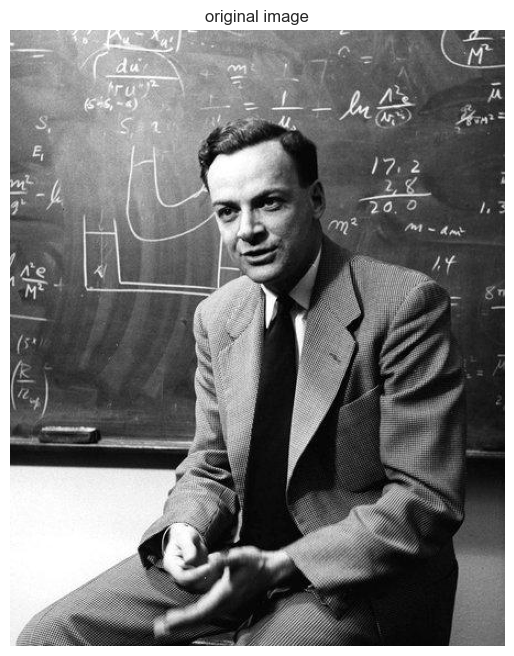

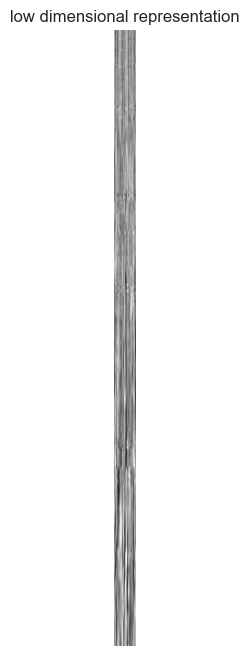

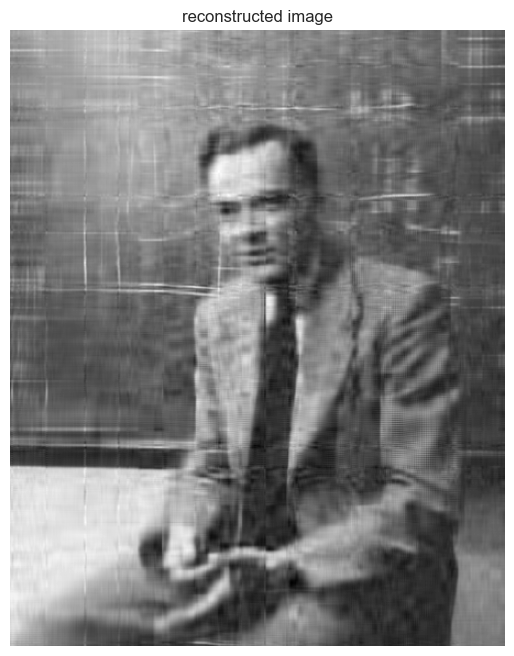

In [68]:
X_rec, Y = AE(X_input)
X_rec = AE.postprocess(X_rec)
show(np_img, title = 'original image')
show(Y.cpu().detach().numpy(), title = 'low dimensional representation')
show(X_rec.cpu().detach().numpy(), title = 'reconstructed image')

The reconstructed image has a similar quality to the PCA's image. However, as we can see from the low dimensional representation, Autoencoder has computed a slightly different set of features. Let's look at the correlation matrix.

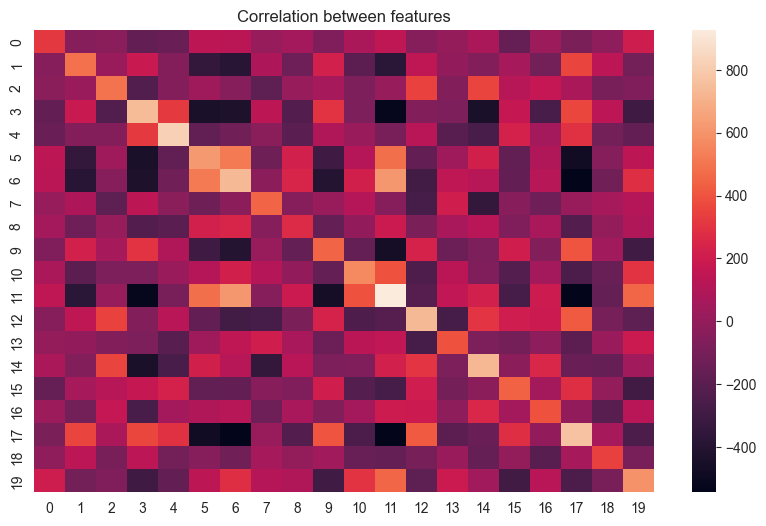

In [69]:
plot_covariance(Y.cpu().detach().numpy())

Here, Autoencder performed much worse in terms of selecting uncorrelated features, but what about the recontruction loss?

In [70]:
print('MSE Recnostruction Loss:', criterion(torch_img, X_rec).item())

MSE Recnostruction Loss: 494.49969482421875


**Expected output:**

MSE Recnostruction Loss: 494.5358581542969 

As we can see, in terms of reconstruction loss, Tied 1-layer Autoencder acheived the results almost identical to PCA.

## Deep Auto Encoder (optional)

The main difference between regular Auteoncder and tied Autoencoder is that we initialize encoding and decoding matrices separately instead of transposing one matrix $W$. This allows us to have more trainable parameters. 

Also, in **Deep Autoencoder**, we don't restrain ourselves to just one matrix for the encoder and decoder. We will use two `Linear` blocks for each, followed by the `ReLU` activation function to introduce non-linearity to our functions. 

In [71]:
class DeepAutoencoder(nn.Module):
    def __init__(self, num_features=Config.num_features, num_hidden=Config.num_hidden):
        super(DeepAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 2*num_hidden),
            nn.ReLU(),
            nn.Linear(2*num_hidden, num_hidden),   
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden, 2*num_hidden),
            nn.ReLU(),
            nn.Linear(2*num_hidden, num_features))

    def preprocess(self, x):
        self.mean = x.mean(dim=0)
        self.std = x.std(dim=0)
        x_norm = (x - self.mean) / self.std
        return x_norm

    def postprocess(self, x):
        x = x * self.std + self.mean
        return x

    def forward(self, x):
        # normalizes input
        y = self.encoder(x)
        x_hat = self.decoder(y)
        return x_hat, y

In [72]:
set_seed(21)
AE = DeepAutoencoder().to(Config.device)
X_input = AE.preprocess(torch_img).to(Config.device)
optimizer = optim.Adam(AE.parameters(), lr=Config.learning_rate)
criterion = nn.MSELoss()
final_loss = train(AE, optimizer, X_input, criterion)
print('Final loss:', final_loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

Final loss: 0.11778337508440018


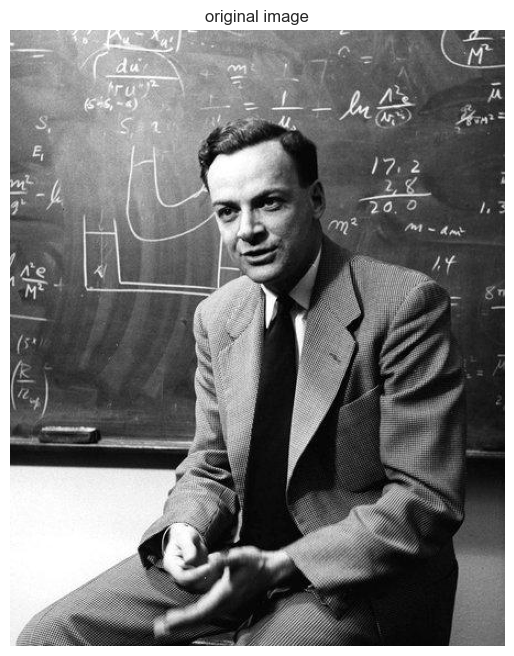

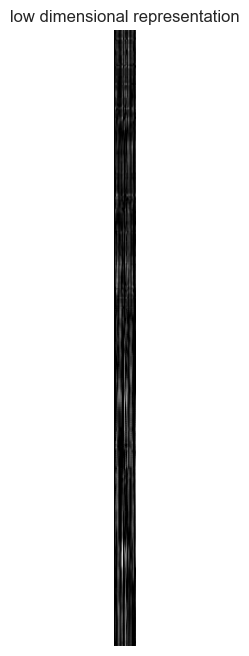

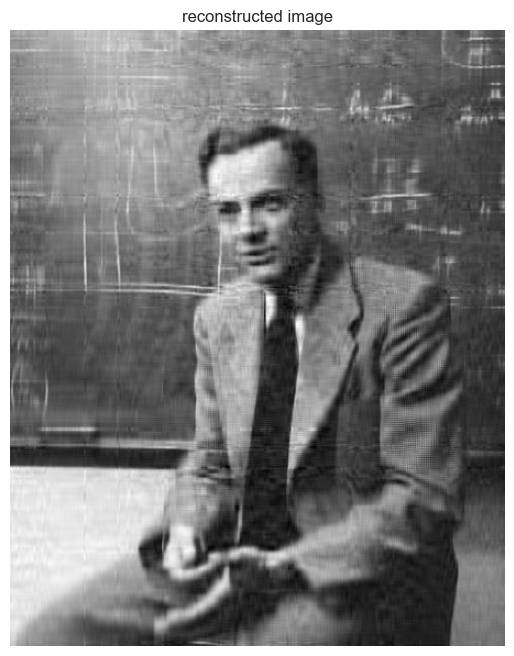

In [73]:
X_rec, Y = AE(X_input)
X_rec = AE.postprocess(X_rec)
show(np_img, title = 'original image')
show(Y.cpu().detach().numpy(), title = 'low dimensional representation')
show(X_rec.cpu().detach().numpy(), title = 'reconstructed image')

As you can see the quality of the reconstructed image has improved considerably.

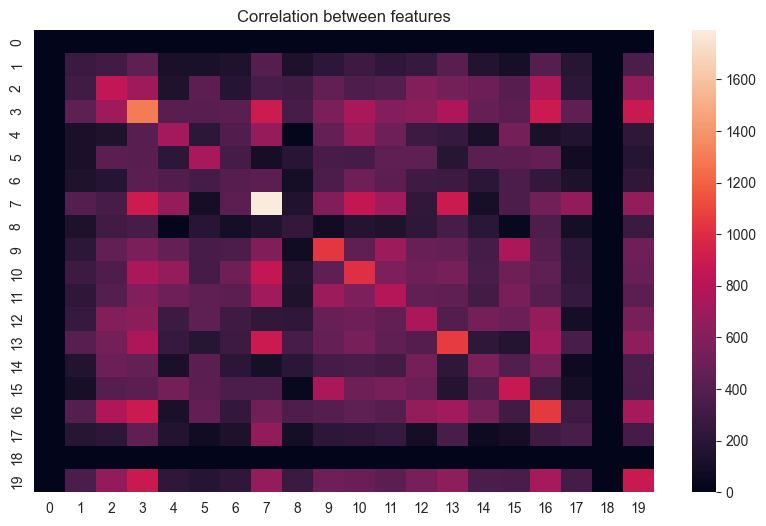

In [74]:
plot_covariance(Y.cpu().detach().numpy())

The covariance matrix has a clear non-linear correlation pattern.

In [75]:
print('MSE Recnostruction Loss:', criterion(torch_img, X_rec).item())

MSE Recnostruction Loss: 390.23388671875


**Expected output:**
    
MSE Recnostruction Loss: 388.3708190917969

And the reconstruction loss for this model is more than 100 lower than for the other models!

# 6 - Conclusions

As we can see from the results, we can use both the Autoencoder and the PCA algorithms to solve the image compression task.

Important takeaways:
1. PCA has comparable performance to a Tied 1-layer Autoencoder
    * but Deep Autoencoder outperforms both models due to its ability to compute non-linear transformation functions
2. Both PCA and Tied 1-layer Autoencoder has the same objective, but they achieve it differently
    * Tied 1-layer Autoencoder trains using backpropagation, minimizing the Reconstruction loss
    * PCA uses eigendecomposition of the covariance matrix
3. PCA is ideal for selecting uncorrelated features, while all Autoencoders are not optimal for this task.